# **Dynamic Pricing & Travel** - Analysis on Airfare From Jakarta

This project analyzes flight ticket price patterns from Jakarta to various domestic destinations in Indonesia. The analysis includes price distribution, most popular destinations, time patterns, price volatility, and business recommendations.

## **1. Setup Environment & Import Libraries**
Import the required libraries and set the visualization configuration for consistent chart display.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")

## **2. Loading and Understanding Data**

Loads the main dataset from a CSV file and displays a preview of the data and basic information about the dataset structure.

In [40]:
print("=== LOADING Main Dataset ===")
file_path = "data/tiketcom_bestprice.csv"
df = pd.read_csv(file_path, sep="|")

print("Preview Dataset:")
print(df.head())

print("\nInformasi Dataset:")
df.info()

print("\nSample origin values:")
print(df['origin'].unique())

=== LOADING Main Dataset ===
Preview Dataset:
            extract_timestamp origin destination depart_date  best_price
0  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-25   2310582.0
1  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-04   2310582.0
2  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-27   2310582.0
3  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-29   2310582.0
4  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-01   2316313.0

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45438 entries, 0 to 45437
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   extract_timestamp  45438 non-null  object 
 1   origin             45438 non-null  object 
 2   destination        45438 non-null  object 
 3   depart_date        45438 non-null  object 
 4   best_price         45438 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


# **3. Data Preprocessing**

Clean and process data with data type conversion, handling missing values, and data filtering, all from Jakarta. The `clean_price` function handles inconsistent price formats.

In [41]:
# Data Cleaning dan Preprocessing
print("\n=== DATA CLEANING ===")

# Konversi tipe data
df['extract_timestamp'] = pd.to_datetime(df['extract_timestamp'])
df['depart_date'] = pd.to_datetime(df['depart_date'])

# PERBAIKAN: Konversi best_price
print("Sample best_price sebelum konversi:")
print(df['best_price'].head(10))

def clean_price(price):
    if pd.isna(price):
        return np.nan
    if isinstance(price, (int, float)):
        return float(price)
    if isinstance(price, str):
        cleaned = ''.join(c for c in price if c.isdigit() or c in ['.', ','])
        cleaned = cleaned.replace(',', '.')
        if cleaned.count('.') > 1:
            parts = cleaned.split('.')
            cleaned = parts[0] + '.' + ''.join(parts[1:])
        try:
            return float(cleaned) if cleaned else np.nan
        except:
            return np.nan
    return np.nan

df['best_price'] = df['best_price'].apply(clean_price)

print("\nSample best_price setelah konversi:")
print(df['best_price'].head(10))

# PERBAIKAN UTAMA: Filter Jakarta dengan benar
# Origin berisi 'JKTC' atau 'CGK', bukan 'Jakarta'
print("\nFilter data dari Jakarta...")
df = df[df['origin'].isin(['JKTC', 'CGK', 'JKT'])]
print(f"Jumlah data dari Jakarta: {len(df):,}")

# Handle missing values
print("\nMissing values sebelum cleaning:")
print(df.isnull().sum())

df = df.dropna(subset=['best_price'])
df = df[df['best_price'] > 0]

print(f"\nJumlah data setelah cleaning: {len(df):,}")
print(f"Range harga: Rp {df['best_price'].min():,.0f} - Rp {df['best_price'].max():,.0f}")


=== DATA CLEANING ===
Sample best_price sebelum konversi:
0    2310582.0
1    2310582.0
2    2310582.0
3    2310582.0
4    2316313.0
5    2474980.0
6    2474980.0
7    2474980.0
8    2474980.0
9    2474980.0
Name: best_price, dtype: float64

Sample best_price setelah konversi:
0    2310582.0
1    2310582.0
2    2310582.0
3    2310582.0
4    2316313.0
5    2474980.0
6    2474980.0
7    2474980.0
8    2474980.0
9    2474980.0
Name: best_price, dtype: float64

Filter data dari Jakarta...
Jumlah data dari Jakarta: 45,438

Missing values sebelum cleaning:
extract_timestamp    0
origin               0
destination          0
depart_date          0
best_price           0
dtype: int64

Jumlah data setelah cleaning: 45,438
Range harga: Rp 367,200 - Rp 5,226,620


## **4. Feature Engineering**
Created new features for temporal analysis such as days to departure, day of week, and weekend/weekday classification.

In [42]:
# Feature Engineering
print("\n=== FEATURE ENGINEERING ===")

df['days_until_departure'] = (df['depart_date'] - df['extract_timestamp']).dt.days
df['depart_day_of_week'] = df['depart_date'].dt.day_name()
df['depart_month'] = df['depart_date'].dt.month
df['depart_is_weekend'] = df['depart_date'].dt.dayofweek >= 5
df['extract_day_of_week'] = df['extract_timestamp'].dt.day_name()

weekend_days = ['Saturday', 'Sunday']
df['depart_day_type'] = df['depart_day_of_week'].apply(
    lambda x: 'Weekend' if x in weekend_days else 'Weekday'
)

print("Fitur yang telah ditambahkan:")
print(df[['days_until_departure', 'depart_day_of_week', 'depart_day_type']].head())


=== FEATURE ENGINEERING ===
Fitur yang telah ditambahkan:
   days_until_departure depart_day_of_week depart_day_type
0                   121            Tuesday         Weekday
1                   100            Tuesday         Weekday
2                   123           Thursday         Weekday
3                   125           Saturday         Weekend
4                    97           Saturday         Weekend


## **5. Exploratory Data Analysis**

### **5.1 Descriptive Statistics**

Displays basic descriptive statistics to understand the distribution and characteristics of ticket prices.

In [43]:
print(f"\nJumlah data: {len(df):,}")
print(f"Rentang harga: Rp {df['best_price'].min():,.0f} - Rp {df['best_price'].max():,.0f}")
print(f"Harga rata-rata: Rp {df['best_price'].mean():,.0f}")
print(f"Median harga: Rp {df['best_price'].median():,.0f}")
print(f"Standar deviasi: Rp {df['best_price'].std():,.0f}")


Jumlah data: 45,438
Rentang harga: Rp 367,200 - Rp 5,226,620
Harga rata-rata: Rp 1,491,694
Median harga: Rp 1,046,760
Standar deviasi: Rp 1,087,001


### **5.2 Distribution Analysis**

Visualization of price distributions with various perspectives - distribution of 95% of the data, distribution up to Rp 5 million, and boxplots to see outliers.

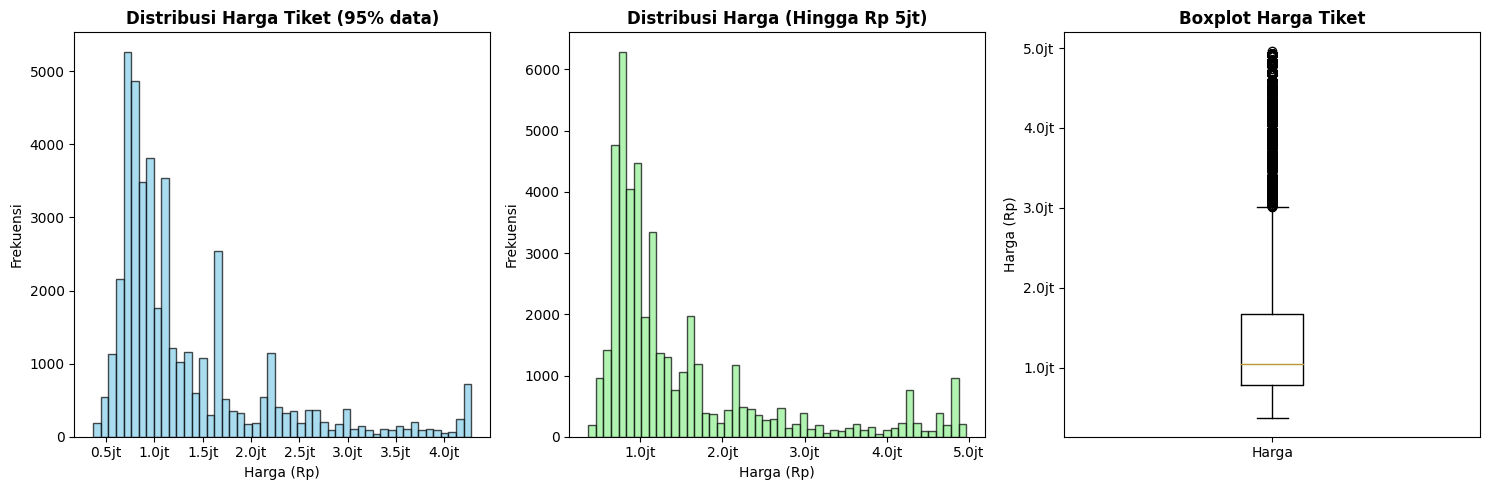

In [44]:
# Distribusi Harga
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
price_q95 = df['best_price'].quantile(0.95)
df_filtered = df[df['best_price'] <= price_q95]
plt.hist(df_filtered['best_price'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribusi Harga Tiket (95% data)', fontweight='bold')
plt.xlabel('Harga (Rp)')
plt.ylabel('Frekuensi')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.subplot(1, 3, 2)
df_reasonable = df[df['best_price'] <= 5000000]
plt.hist(df_reasonable['best_price'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Distribusi Harga (Hingga Rp 5jt)', fontweight='bold')
plt.xlabel('Harga (Rp)')
plt.ylabel('Frekuensi')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.subplot(1, 3, 3)
plt.boxplot(df_reasonable['best_price'])
plt.title('Boxplot Harga Tiket', fontweight='bold')
plt.ylabel('Harga (Rp)')
plt.xticks([1], ['Harga'])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.tight_layout()
plt.show()

## **5.3 Top Destinations Analysis**

Analysis of the most popular destinations from Jakarta with bar chart visualization and ranking list.


=== TOP 10 DESTINASI TERPOPULER ===


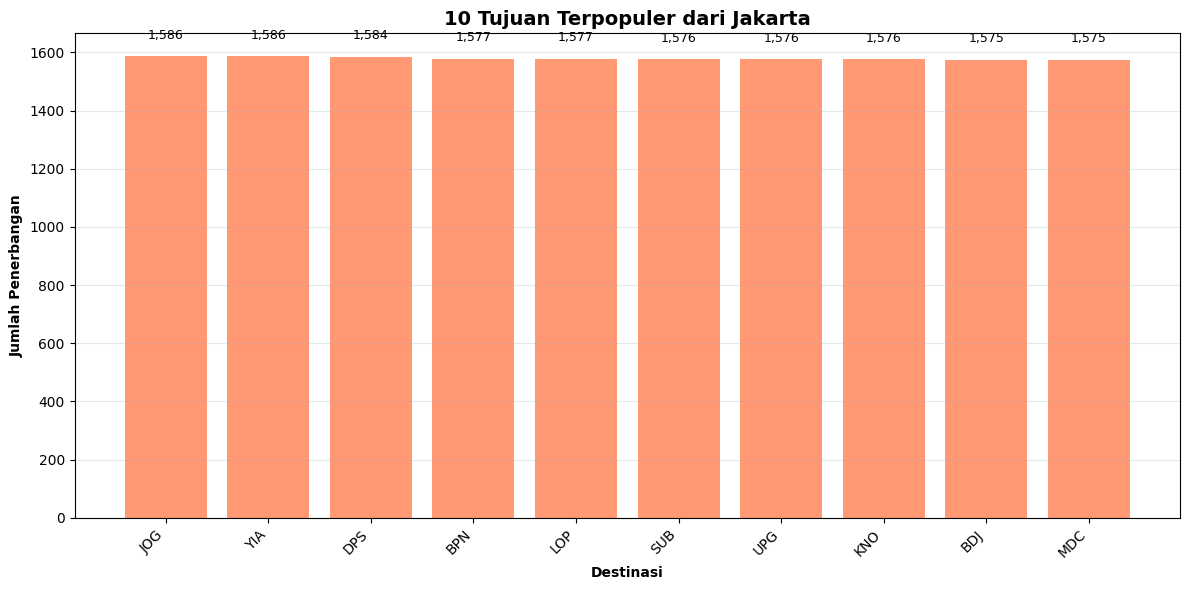


Top 10 Destinasi:
1. JOG: 1,586 penerbangan
2. YIA: 1,586 penerbangan
3. DPS: 1,584 penerbangan
4. BPN: 1,577 penerbangan
5. LOP: 1,577 penerbangan
6. SUB: 1,576 penerbangan
7. UPG: 1,576 penerbangan
8. KNO: 1,576 penerbangan
9. BDJ: 1,575 penerbangan
10. MDC: 1,575 penerbangan


In [ ]:
top_destinations = df['destination'].value_counts().head(10)

if len(top_destinations) > 0:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(top_destinations)), top_destinations.values, color='coral', alpha=0.8)
    plt.title('10 Tujuan Terpopuler dari Jakarta', fontsize=14, fontweight='bold')
    plt.xlabel('Destinasi', fontweight='bold')
    plt.ylabel('Jumlah Penerbangan', fontweight='bold')
    plt.xticks(range(len(top_destinations)), top_destinations.index, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, top_destinations.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{val:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Destinasi:")
    for i, (dest, count) in enumerate(top_destinations.items(), 1):
        print(f"{i}. {dest}: {count:,} penerbangan")
else:
    print("Tidak ada data destinasi")

## **5.4 Price Analysis by Destination**

Statistical analysis of prices for the most popular destinations, including comparison of average prices between destinations.

Statistik Harga untuk Top 10 Destinasi:
             count       mean     median       std        min        max
destination                                                             
MDC           1575  2509443.0  2700630.0  384637.0  1337441.0  2999891.0
JOG           1586  1619770.0  1642875.0   90946.0  1122400.0  2722480.0
UPG           1576  1416529.0  1504030.0  259789.0   882350.0  1764730.0
BDJ           1575  1247739.0  1142800.0  303981.0   717600.0  3142330.0
BPN           1577  1219658.0  1188130.0  282403.0   800530.0  1923802.0
KNO           1576  1075228.0   953450.0  243594.0   789630.0  1717150.0
LOP           1577   988898.0   962819.0  188835.0   682700.0  1601801.0
DPS           1584   780284.0   778052.0   78329.0   660621.0  1203000.0
SUB           1576   730677.0   732897.0   75537.0   562931.0  1365200.0
YIA           1586   595521.0   562480.0  111363.0   367200.0   924120.0


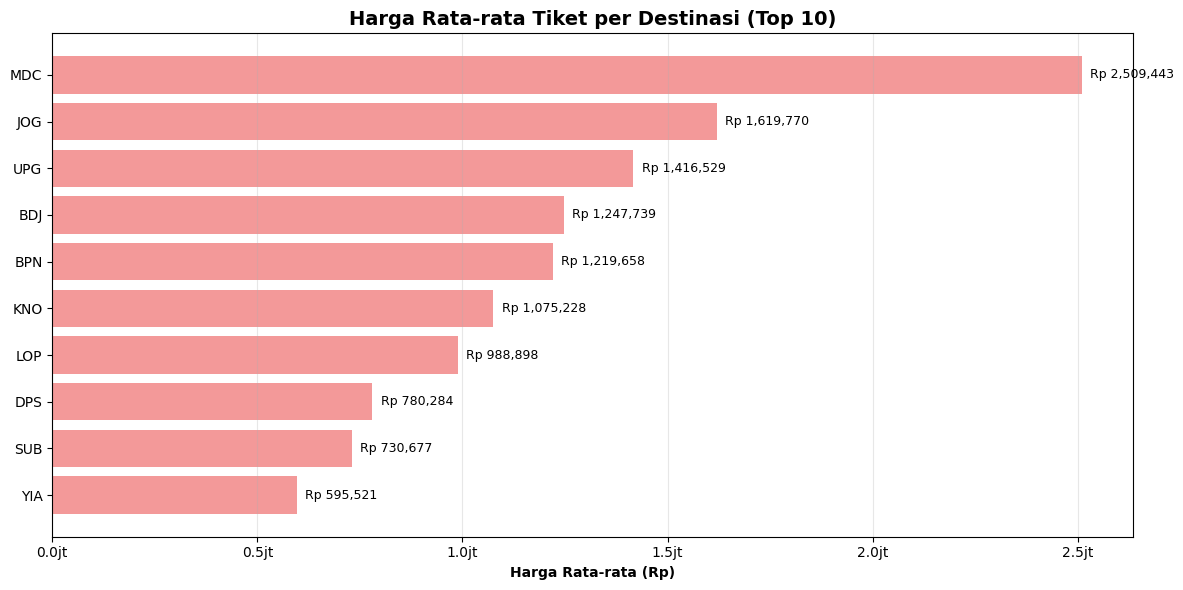

In [46]:
if len(top_destinations) > 0:
    top_10_dests = top_destinations.index.tolist()
    harga_per_destinasi = df[df['destination'].isin(top_10_dests)].groupby('destination')['best_price'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(0).sort_values('mean', ascending=False)

    print("Statistik Harga untuk Top 10 Destinasi:")
    print(harga_per_destinasi)

    plt.figure(figsize=(12, 6))
    harga_sorted = harga_per_destinasi['mean'].sort_values(ascending=True)
    bars = plt.barh(range(len(harga_sorted)), harga_sorted.values, color='lightcoral', alpha=0.8)
    plt.yticks(range(len(harga_sorted)), harga_sorted.index)
    plt.title('Harga Rata-rata Tiket per Destinasi (Top 10)', fontsize=14, fontweight='bold')
    plt.xlabel('Harga Rata-rata (Rp)', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for bar, val in zip(bars, harga_sorted.values):
        plt.text(bar.get_width() + 20000, bar.get_y() + bar.get_height()/2,
                f'Rp {val:,.0f}', va='center', fontsize=9)
    
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))
    plt.tight_layout()
    plt.show()

## **5.5 Temporal Pattern Analysis**

Time-based price pattern analysis - price comparison between days of the week and weekend price premium analysis.


=== ANALISIS POLA WAKTU ===


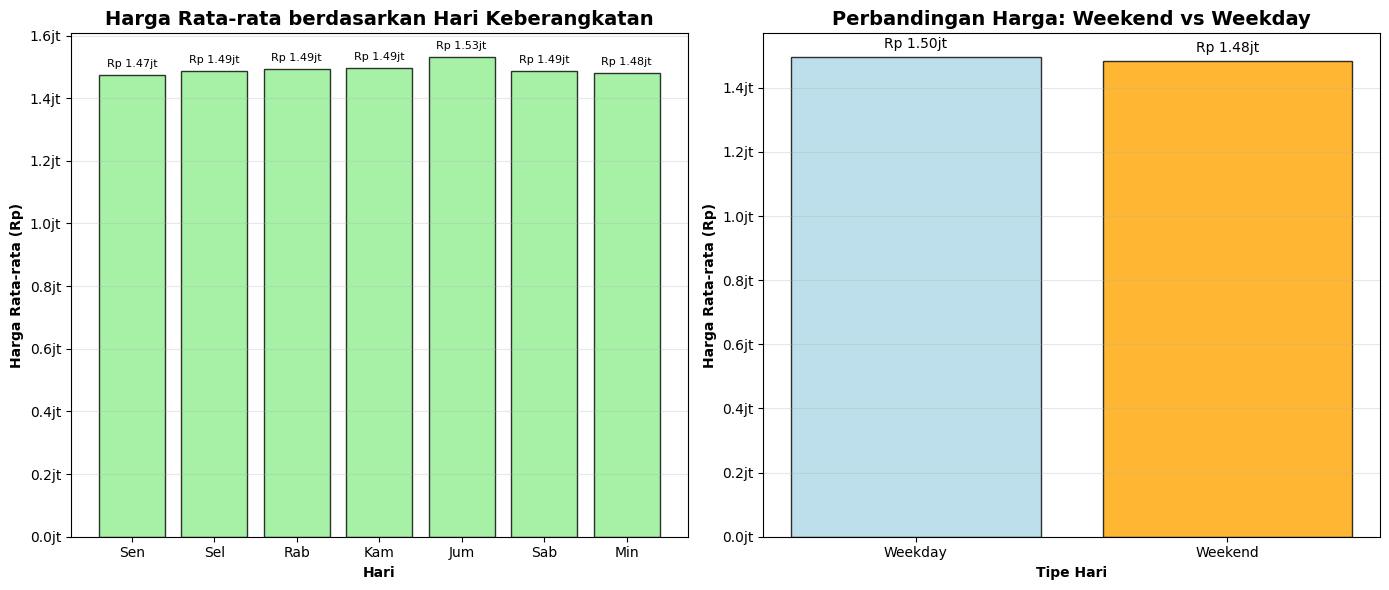


Perbedaan Harga Weekend vs Weekday:
Weekday: Rp 1,495,233
Weekend: Rp 1,482,858
Selisih: -0.8%


In [ ]:
harga_per_hari = df.groupby('depart_day_of_week')['best_price'].agg(['mean', 'median'])
all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
harga_per_hari = harga_per_hari.reindex(all_days)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(harga_per_hari)), harga_per_hari['mean'].values, 
               color='lightgreen', alpha=0.8, edgecolor='black')
plt.title('Harga Rata-rata berdasarkan Hari Keberangkatan', fontsize=14, fontweight='bold')
plt.xlabel('Hari', fontweight='bold')
plt.ylabel('Harga Rata-rata (Rp)', fontweight='bold')
plt.xticks(range(len(all_days)), ['Sen', 'Sel', 'Rab', 'Kam', 'Jum', 'Sab', 'Min'])
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, harga_per_hari['mean'].values):
    if not np.isnan(value):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,
                f'Rp {value/1e6:.2f}jt', ha='center', va='bottom', fontsize=8)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.subplot(1, 2, 2)
weekend_vs_weekday = df.groupby('depart_day_type')['best_price'].mean()
bars2 = plt.bar(range(len(weekend_vs_weekday)), weekend_vs_weekday.values,
                color=['lightblue', 'orange'], alpha=0.8, edgecolor='black')
plt.title('Perbandingan Harga: Weekend vs Weekday', fontsize=14, fontweight='bold')
plt.xlabel('Tipe Hari', fontweight='bold')
plt.ylabel('Harga Rata-rata (Rp)', fontweight='bold')
plt.xticks(range(len(weekend_vs_weekday)), weekend_vs_weekday.index)
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars2, weekend_vs_weekday.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,
            f'Rp {value/1e6:.2f}jt', ha='center', va='bottom', fontsize=10)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.tight_layout()
plt.show()

if 'Weekend' in weekend_vs_weekday.index and 'Weekday' in weekend_vs_weekday.index:
    weekend_price = weekend_vs_weekday['Weekend']
    weekday_price = weekend_vs_weekday['Weekday']
    price_diff_percent = ((weekend_price - weekday_price) / weekday_price) * 100

    print(f"\nPerbedaan Harga Weekend vs Weekday:")
    print(f"Weekday: Rp {weekday_price:,.0f}")
    print(f"Weekend: Rp {weekend_price:,.0f}")
    print(f"Selisih: {price_diff_percent:+.1f}%")

## **5.6 Monthly Trend Analysis**
Analyze monthly price trends to identify seasonal patterns in airfare prices.

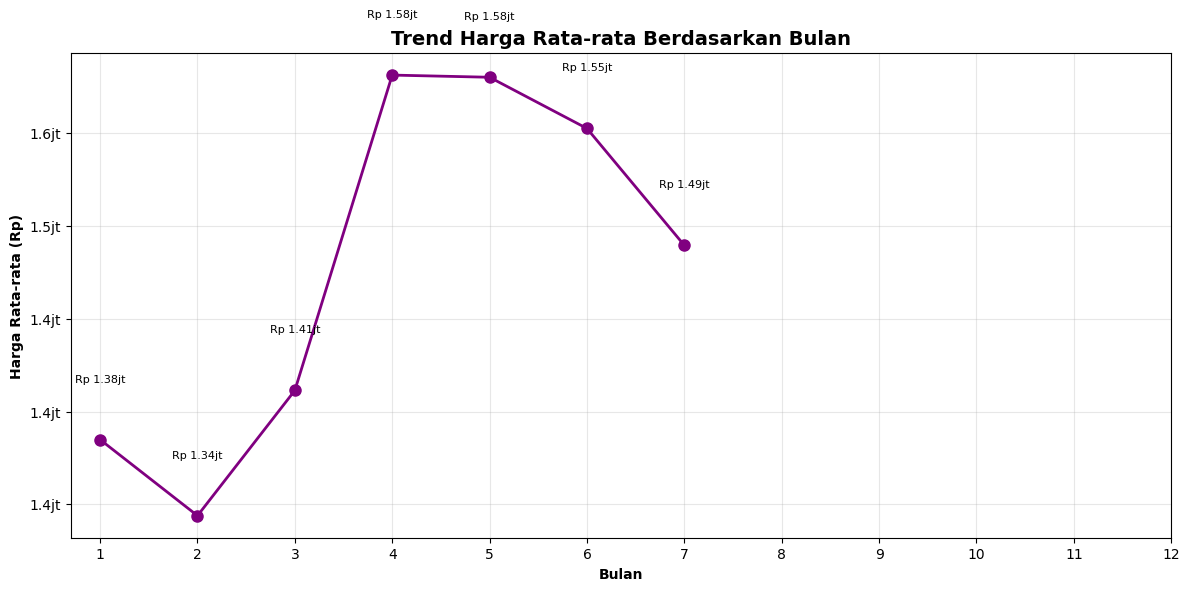

In [48]:
# Analisis berdasarkan bulan
harga_per_bulan = df.groupby('depart_month')['best_price'].mean()

plt.figure(figsize=(12, 6))
plt.plot(harga_per_bulan.index, harga_per_bulan.values, marker='o', 
         color='purple', linewidth=2, markersize=8)
plt.title('Trend Harga Rata-rata Berdasarkan Bulan', fontsize=14, fontweight='bold')
plt.xlabel('Bulan', fontweight='bold')
plt.ylabel('Harga Rata-rata (Rp)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

for month, price in harga_per_bulan.items():
    plt.text(month, price + 30000, f'Rp {price/1e6:.2f}jt', 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## **5.7 Volatility Analysis**

Price volatility analysis uses the Coefficient of Variation (CV) to identify destinations with the highest price fluctuations.

Top 10 Destinasi dengan Volatilitas Tertinggi:
             count    mean_price    std_price      cv
destination                                          
BDJ           1575  1.247739e+06  303981.1126  0.2436
BDO           1540  2.567488e+06  596597.9762  0.2324
BPN           1577  1.219658e+06  282402.8551  0.2315
KNO           1576  1.075228e+06  243593.5551  0.2266
PNK           1575  1.234637e+06  268957.2775  0.2178
MLG           1573  1.084793e+06  220953.4311  0.2037
PDG           1574  1.054531e+06  204370.1132  0.1938
LOP           1577  9.888983e+05  188834.7990  0.1910
TNJ           1572  1.175235e+06  223722.1838  0.1904
BTJ           1573  2.091568e+06  394764.1553  0.1887


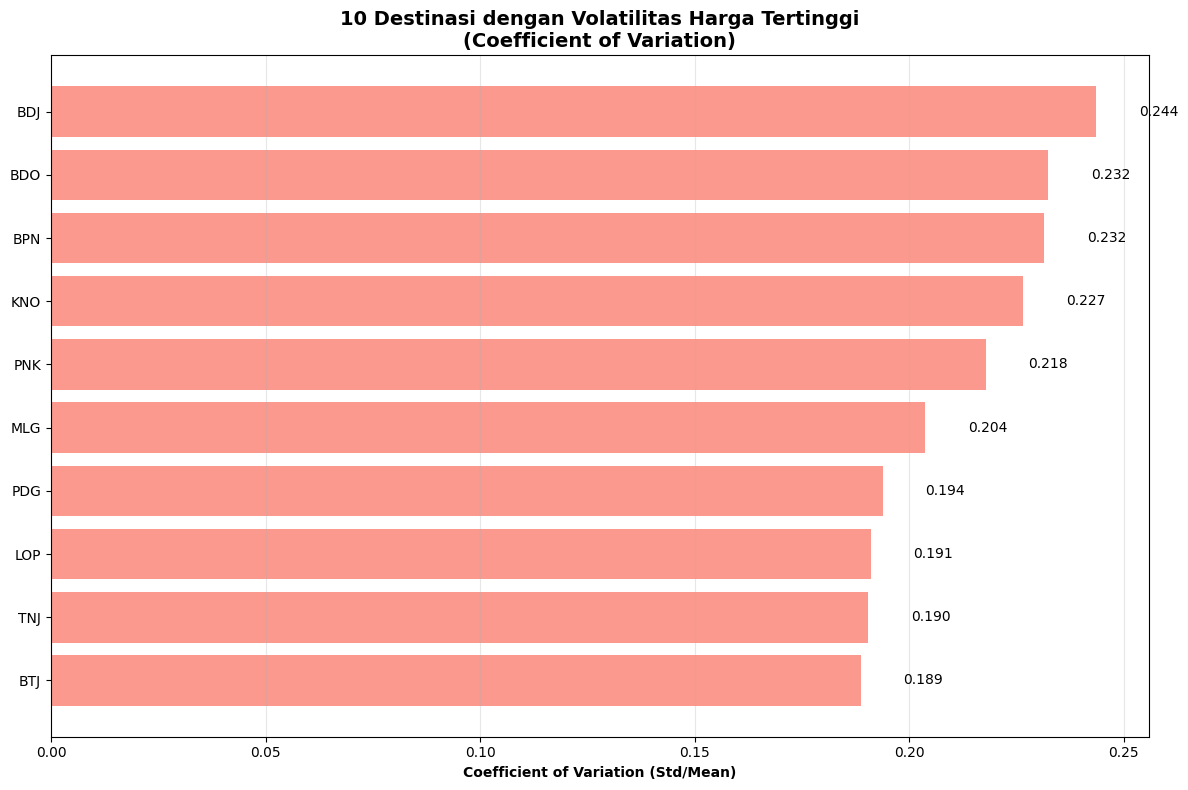

In [49]:
volatility_analysis = df.groupby('destination')['best_price'].agg([
    ('count', 'count'),
    ('mean_price', 'mean'),
    ('std_price', 'std'),
    ('cv', lambda x: x.std() / x.mean() if x.mean() > 0 else 0)
]).round(4)

volatility_analysis = volatility_analysis[volatility_analysis['count'] >= 50]
volatility_analysis = volatility_analysis.sort_values('cv', ascending=False)

if len(volatility_analysis) > 0:
    print("Top 10 Destinasi dengan Volatilitas Tertinggi:")
    print(volatility_analysis.head(10))

    plt.figure(figsize=(12, 8))
    top_volatile = volatility_analysis.head(10)['cv'].sort_values(ascending=True)
    bars = plt.barh(range(len(top_volatile)), top_volatile.values, color='salmon', alpha=0.8)
    plt.yticks(range(len(top_volatile)), top_volatile.index)
    plt.title('10 Destinasi dengan Volatilitas Harga Tertinggi\n(Coefficient of Variation)', 
             fontsize=14, fontweight='bold')
    plt.xlabel('Coefficient of Variation (Std/Mean)', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, (bar, value) in enumerate(zip(bars, top_volatile.values)):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## **5.8 Advance Booking Analysis**

Analysis of the relationship between booking time (days until departure) and ticket price, including trends, distribution, and scatter plots.

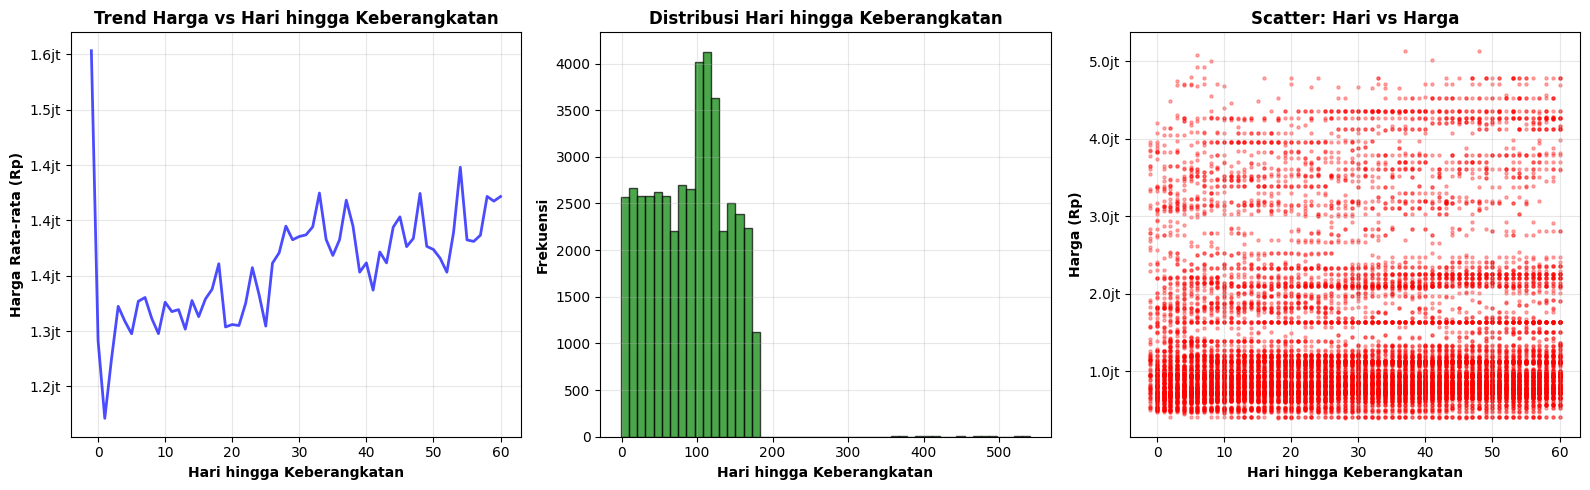

In [50]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
df_sample = df[df['days_until_departure'] <= 60]
days_price = df_sample.groupby('days_until_departure')['best_price'].mean()
plt.plot(days_price.index, days_price.values, color='blue', alpha=0.7, linewidth=2)
plt.title('Trend Harga vs Hari hingga Keberangkatan', fontweight='bold')
plt.xlabel('Hari hingga Keberangkatan', fontweight='bold')
plt.ylabel('Harga Rata-rata (Rp)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.subplot(1, 3, 2)
plt.hist(df['days_until_departure'], bins=50, alpha=0.7, edgecolor='black', color='green')
plt.title('Distribusi Hari hingga Keberangkatan', fontweight='bold')
plt.xlabel('Hari hingga Keberangkatan', fontweight='bold')
plt.ylabel('Frekuensi', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(df_sample['days_until_departure'], df_sample['best_price'], 
           alpha=0.3, s=5, color='red')
plt.title('Scatter: Hari vs Harga', fontweight='bold')
plt.xlabel('Hari hingga Keberangkatan', fontweight='bold')
plt.ylabel('Harga (Rp)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

plt.tight_layout()
plt.show()

## **5.9 Comprehensive Dashboard**

A comprehensive dashboard featuring 4 main visualizations: price distribution per destination, daily price patterns, destination volatility, and advance booking patterns.

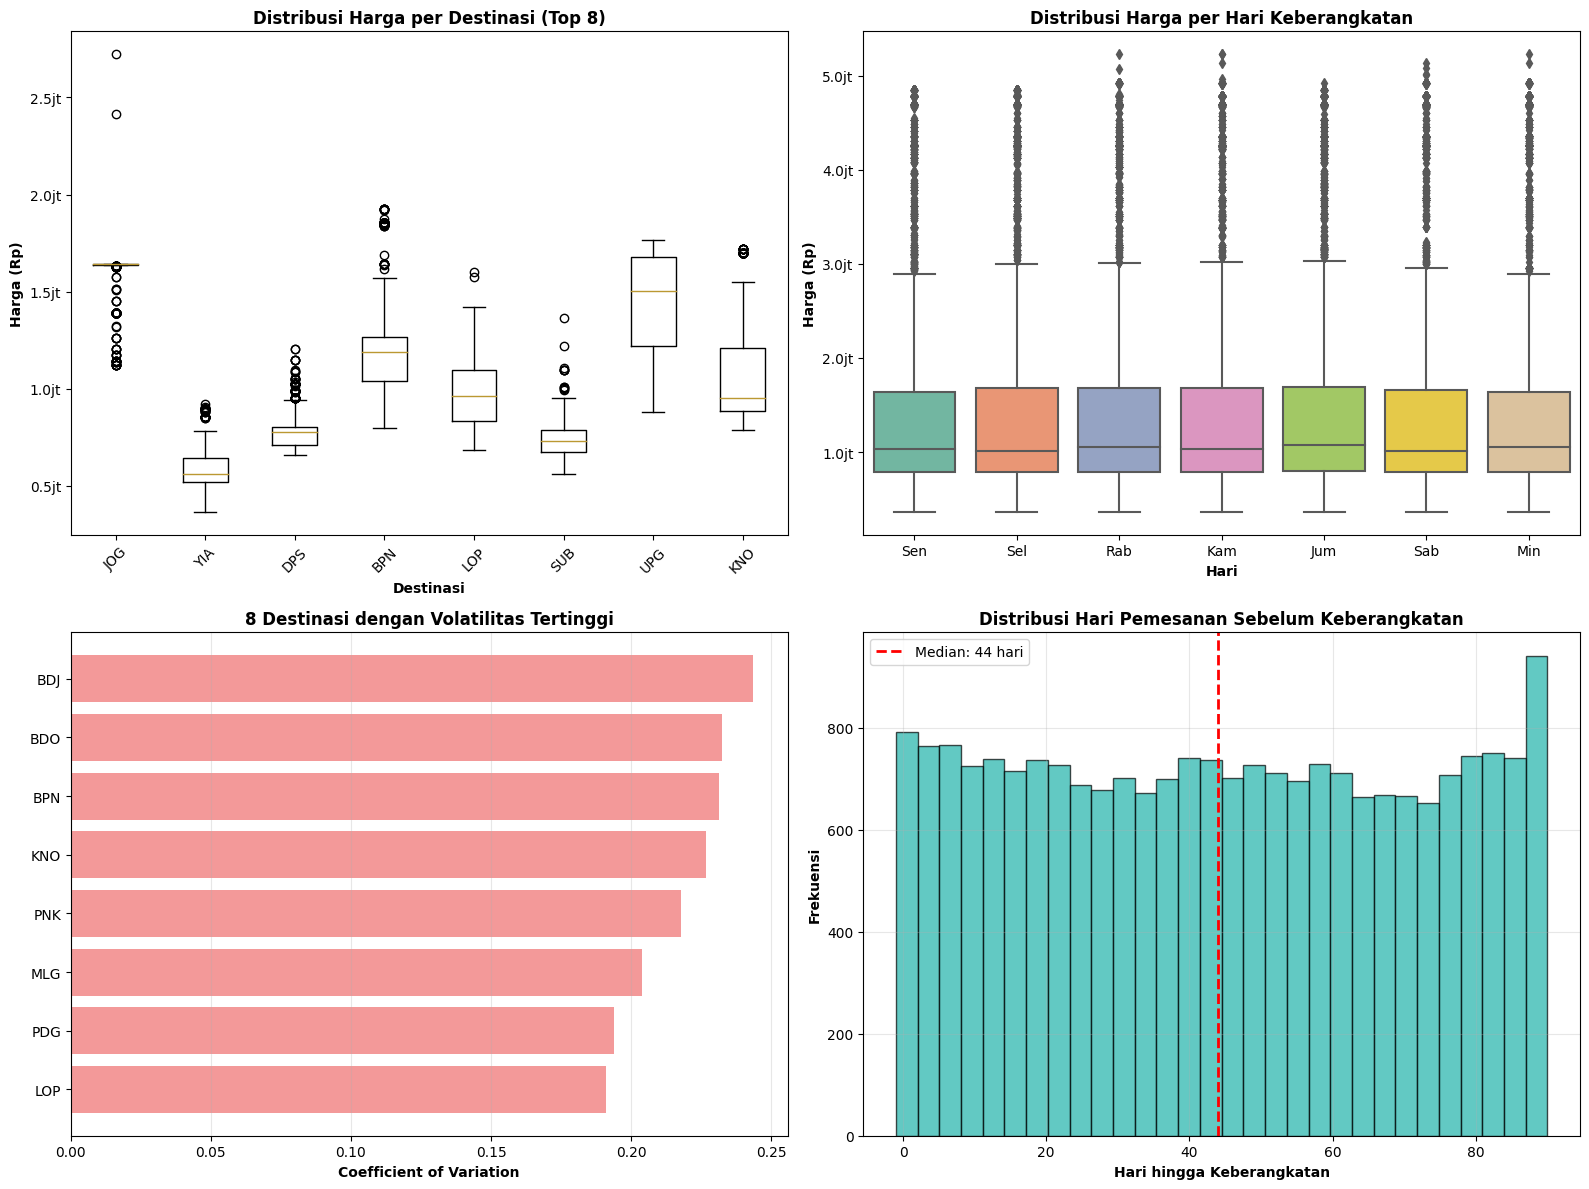

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Boxplot per destinasi
if len(top_destinations) > 0:
    top_8_dests = top_destinations.head(8).index.tolist()
    top_dests_data = df[df['destination'].isin(top_8_dests)]
    
    if len(top_dests_data) > 0:
        box_data = [top_dests_data[top_dests_data['destination'] == dest]['best_price'].values
                   for dest in top_8_dests]
        axes[0,0].boxplot(box_data, labels=top_8_dests)
        axes[0,0].set_title('Distribusi Harga per Destinasi (Top 8)', fontweight='bold')
        axes[0,0].set_xlabel('Destinasi', fontweight='bold')
        axes[0,0].set_ylabel('Harga (Rp)', fontweight='bold')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

# Plot 2: Harga per hari
sns.boxplot(data=df, x='depart_day_of_week', y='best_price',
            order=all_days, ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Distribusi Harga per Hari Keberangkatan', fontweight='bold')
axes[0,1].set_xticklabels(['Sen','Sel','Rab','Kam','Jum','Sab','Min'])
axes[0,1].set_xlabel('Hari', fontweight='bold')
axes[0,1].set_ylabel('Harga (Rp)', fontweight='bold')
axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}jt'))

# Plot 3: Volatilitas
if len(volatility_analysis) > 0:
    top_volatile_plot = volatility_analysis.head(8)['cv'].sort_values(ascending=True)
    y_pos = range(len(top_volatile_plot))
    axes[1,0].barh(y_pos, top_volatile_plot.values, color='lightcoral', alpha=0.8)
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(top_volatile_plot.index)
    axes[1,0].set_title('8 Destinasi dengan Volatilitas Tertinggi', fontweight='bold')
    axes[1,0].set_xlabel('Coefficient of Variation', fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

# Plot 4: Distribusi advance booking
advance_booking = df[df['days_until_departure'] <= 90]['days_until_departure']
axes[1,1].hist(advance_booking, bins=30, edgecolor='black', alpha=0.7, color='lightseagreen')
axes[1,1].set_title('Distribusi Hari Pemesanan Sebelum Keberangkatan', fontweight='bold')
axes[1,1].set_xlabel('Hari hingga Keberangkatan', fontweight='bold')
axes[1,1].set_ylabel('Frekuensi', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

median_days = advance_booking.median()
axes[1,1].axvline(median_days, color='red', linestyle='--', linewidth=2,
                 label=f'Median: {median_days:.0f} hari')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## **5.10 Business Insights & Recommendations**

A summary of key business insights that can be used for ticket booking strategies, including popular destinations, temporal pricing patterns, and booking characteristics.

In [52]:
print("\n📊 KEY INSIGHTS:")

if len(top_destinations) > 0:
    top_3_dests = top_destinations.head(3).index.tolist()
    print(f"1. TOP 3 DESTINASI: {', '.join(top_3_dests)}")

if 'Weekend' in weekend_vs_weekday.index and 'Weekday' in weekend_vs_weekday.index:
    print(f"2. WEEKEND PREMIUM: Harga weekend {price_diff_percent:+.1f}% dari weekday")

if len(volatility_analysis) > 0:
    top_volatile_list = volatility_analysis.head(3).index.tolist()
    print(f"3. VOLATILITAS TERTINGGI: {', '.join(top_volatile_list)}")

price_q25 = df['best_price'].quantile(0.25)
price_q75 = df['best_price'].quantile(0.75)
print(f"4. RENTANG HARGA: Rp {df['best_price'].min():,.0f} - Rp {df['best_price'].max():,.0f}")
print(f"   IQR (25%-75%): Rp {price_q25:,.0f} - Rp {price_q75:,.0f}")

avg_advance_days = df['days_until_departure'].mean()
median_advance_days = df['days_until_departure'].median()
print(f"5. POLA PEMESANAN: Rata-rata {avg_advance_days:.0f} hari, Median {median_advance_days:.0f} hari")


📊 KEY INSIGHTS:
1. TOP 3 DESTINASI: JOG, YIA, DPS
2. WEEKEND PREMIUM: Harga weekend -0.8% dari weekday
3. VOLATILITAS TERTINGGI: BDJ, BDO, BPN
4. RENTANG HARGA: Rp 367,200 - Rp 5,226,620
   IQR (25%-75%): Rp 789,400 - Rp 1,677,930
5. POLA PEMESANAN: Rata-rata 89 hari, Median 95 hari


=== LOADING DATASET UTAMA ===
Preview Dataset:
            extract_timestamp origin destination depart_date  best_price
0  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-25   2310582.0
1  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-04   2310582.0
2  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-27   2310582.0
3  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-29   2310582.0
4  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-01   2316313.0

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45438 entries, 0 to 45437
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   extract_timestamp  45438 non-null  object 
 1   origin             45438 non-null  object 
 2   destination        45438 non-null  object 
 3   depart_date        45438 non-null  object 
 4   best_price         45438 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.7+ MB

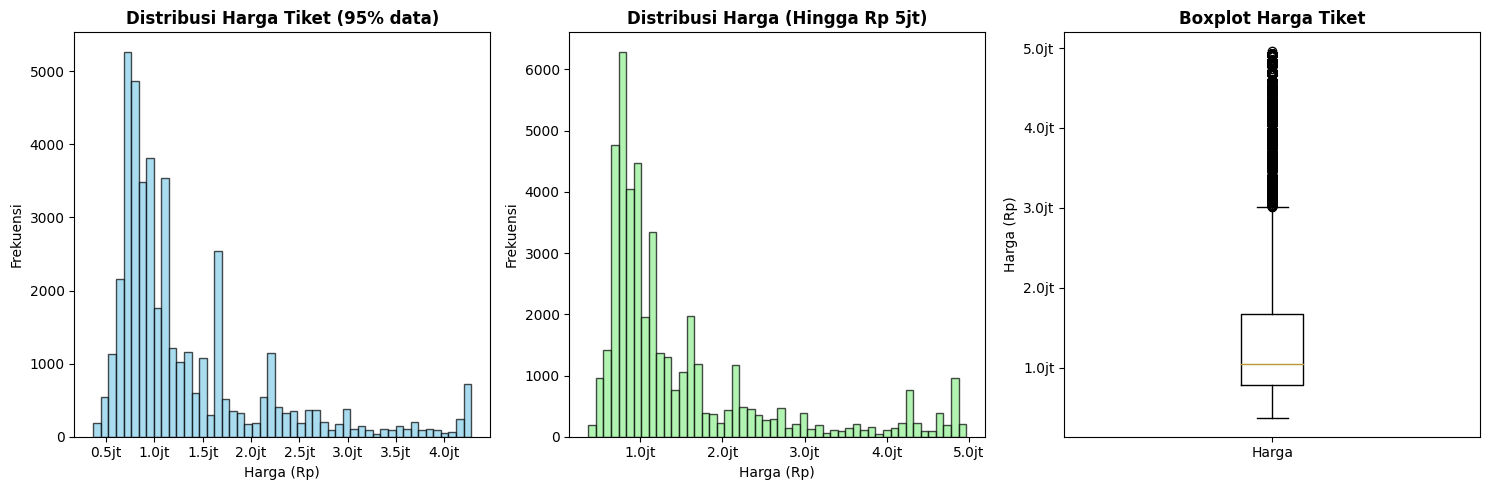


=== TOP 10 DESTINASI TERPOPULER ===


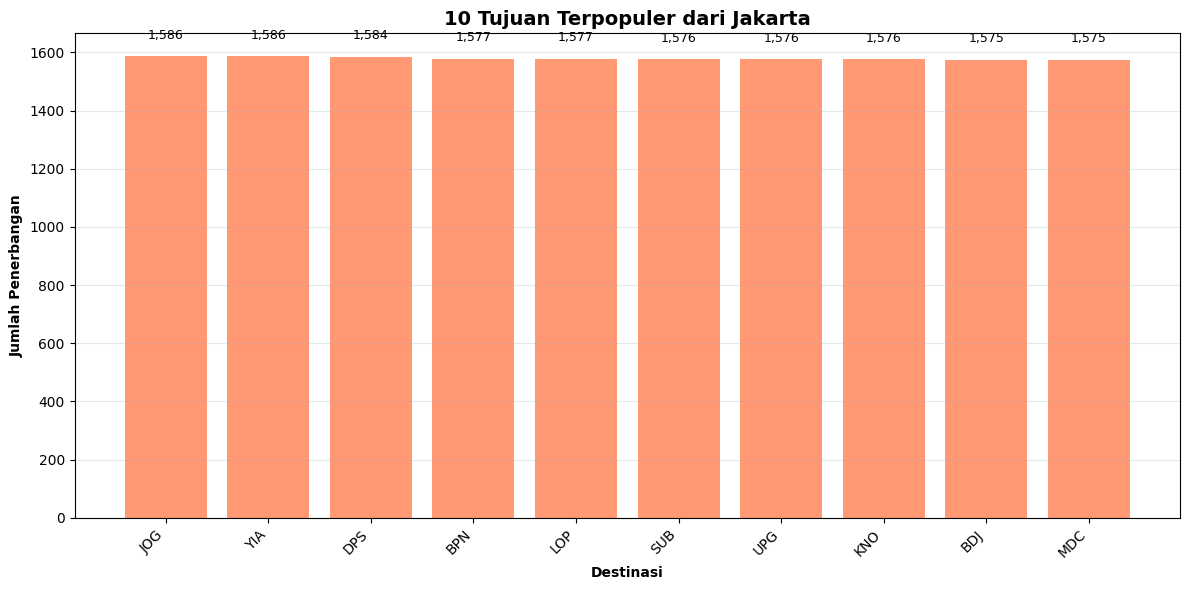


Top 10 Destinasi:
1. JOG: 1,586 penerbangan
2. YIA: 1,586 penerbangan
3. DPS: 1,584 penerbangan
4. BPN: 1,577 penerbangan
5. LOP: 1,577 penerbangan
6. SUB: 1,576 penerbangan
7. UPG: 1,576 penerbangan
8. KNO: 1,576 penerbangan
9. BDJ: 1,575 penerbangan
10. MDC: 1,575 penerbangan

=== ANALISIS HARGA PER DESTINASI ===
Statistik Harga untuk Top 10 Destinasi:
             count       mean     median       std        min        max
destination                                                             
MDC           1575  2509443.0  2700630.0  384637.0  1337441.0  2999891.0
JOG           1586  1619770.0  1642875.0   90946.0  1122400.0  2722480.0
UPG           1576  1416529.0  1504030.0  259789.0   882350.0  1764730.0
BDJ           1575  1247739.0  1142800.0  303981.0   717600.0  3142330.0
BPN           1577  1219658.0  1188130.0  282403.0   800530.0  1923802.0
KNO           1576  1075228.0   953450.0  243594.0   789630.0  1717150.0
LOP           1577   988898.0   962819.0  188835.0   68270

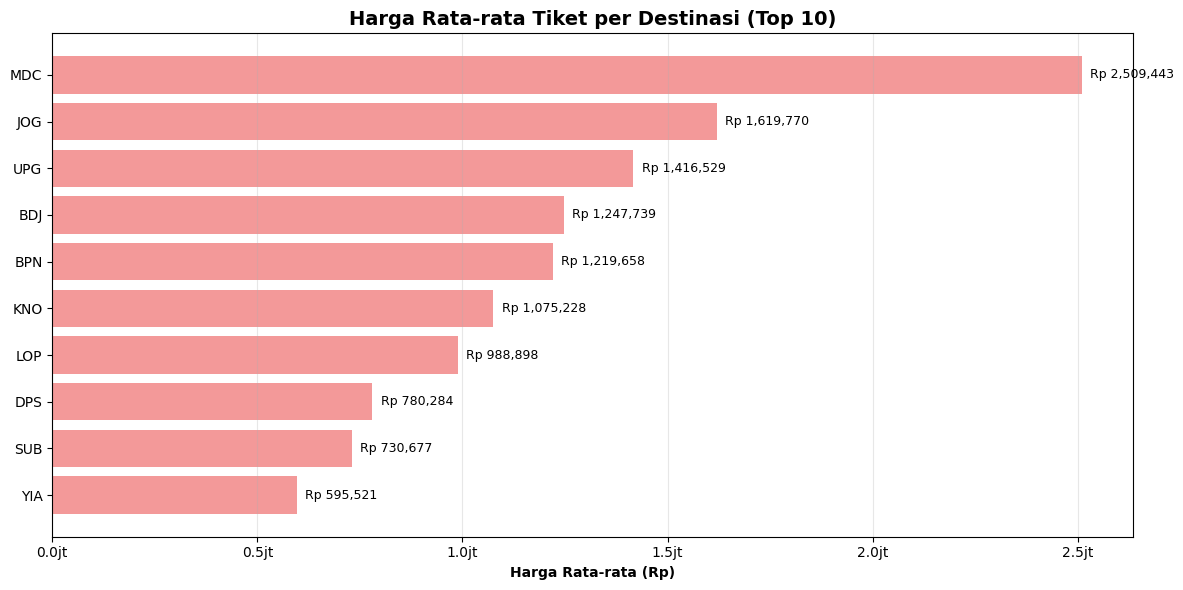


=== ANALISIS POLA WAKTU ===


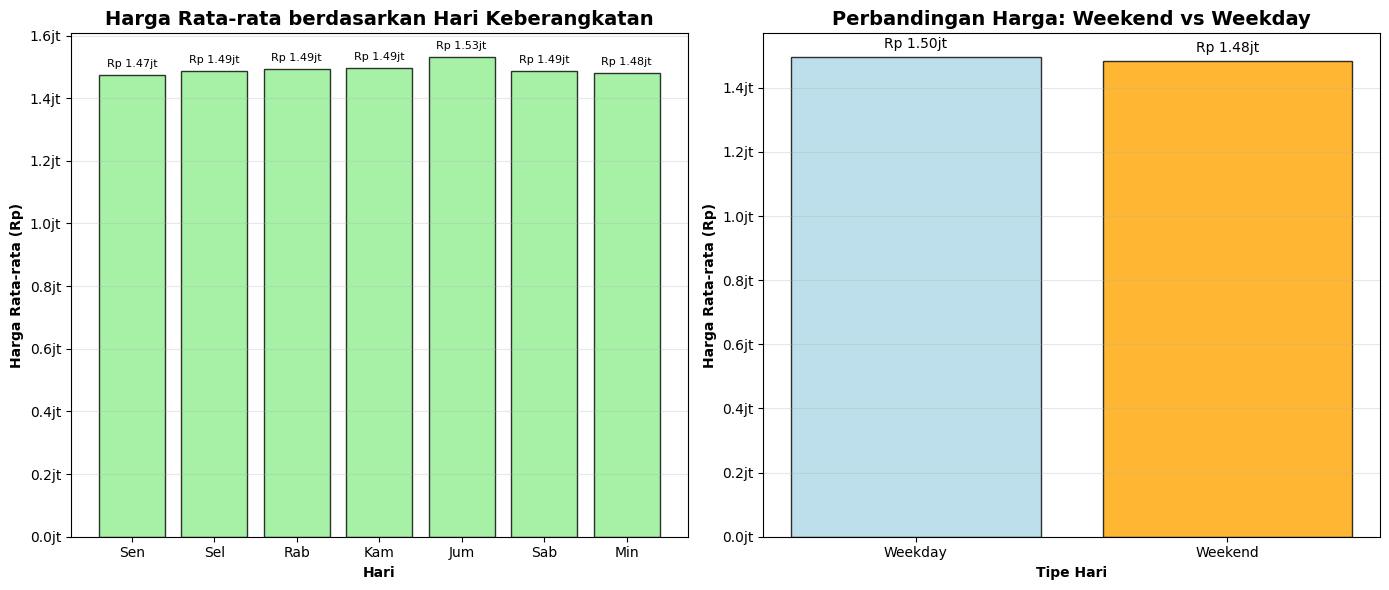


Perbedaan Harga Weekend vs Weekday:
Weekday: Rp 1,495,233
Weekend: Rp 1,482,858
Selisih: -0.8%


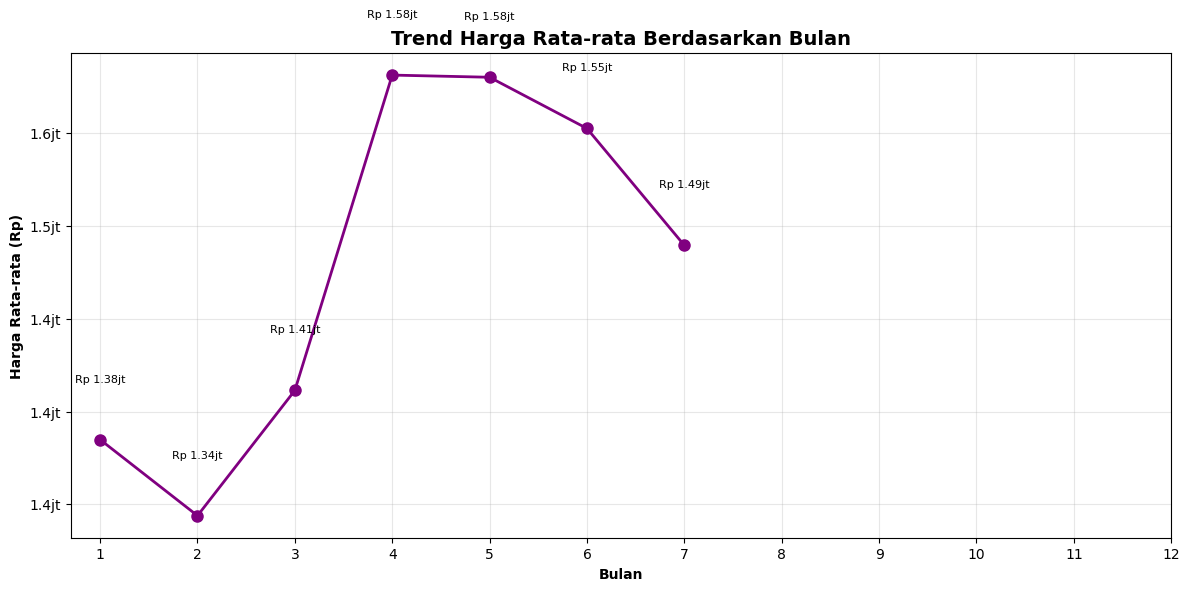


=== ANALISIS VOLATILITAS HARGA ===
Top 10 Destinasi dengan Volatilitas Tertinggi:
             count    mean_price    std_price      cv
destination                                          
BDJ           1575  1.247739e+06  303981.1126  0.2436
BDO           1540  2.567488e+06  596597.9762  0.2324
BPN           1577  1.219658e+06  282402.8551  0.2315
KNO           1576  1.075228e+06  243593.5551  0.2266
PNK           1575  1.234637e+06  268957.2775  0.2178
MLG           1573  1.084793e+06  220953.4311  0.2037
PDG           1574  1.054531e+06  204370.1132  0.1938
LOP           1577  9.888983e+05  188834.7990  0.1910
TNJ           1572  1.175235e+06  223722.1838  0.1904
BTJ           1573  2.091568e+06  394764.1553  0.1887


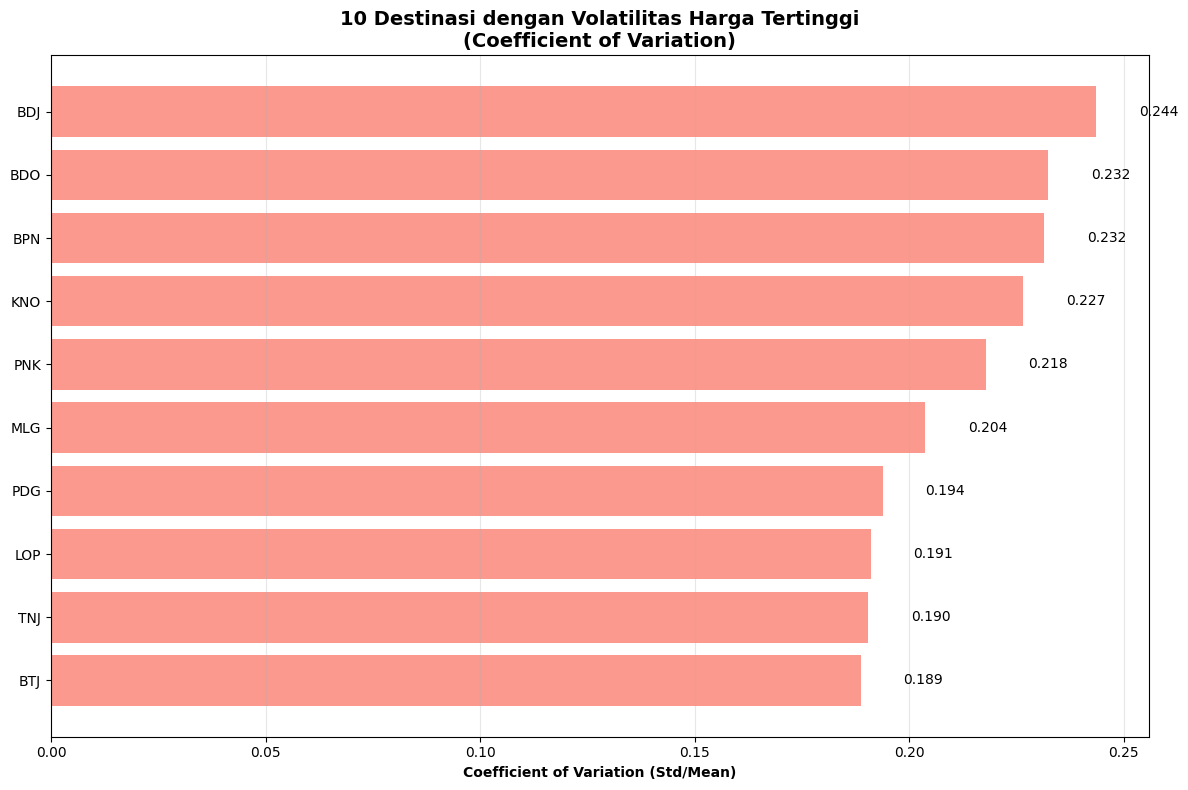


=== ANALISIS DAYS UNTIL DEPARTURE ===


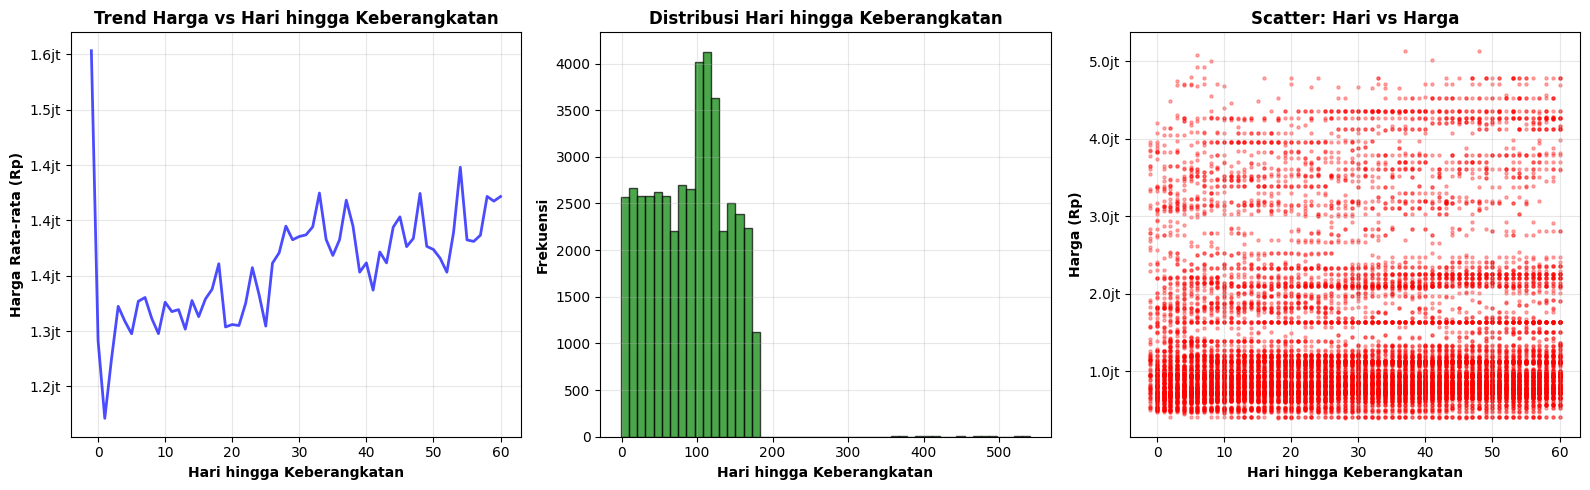


=== DASHBOARD VISUALIZATION ===


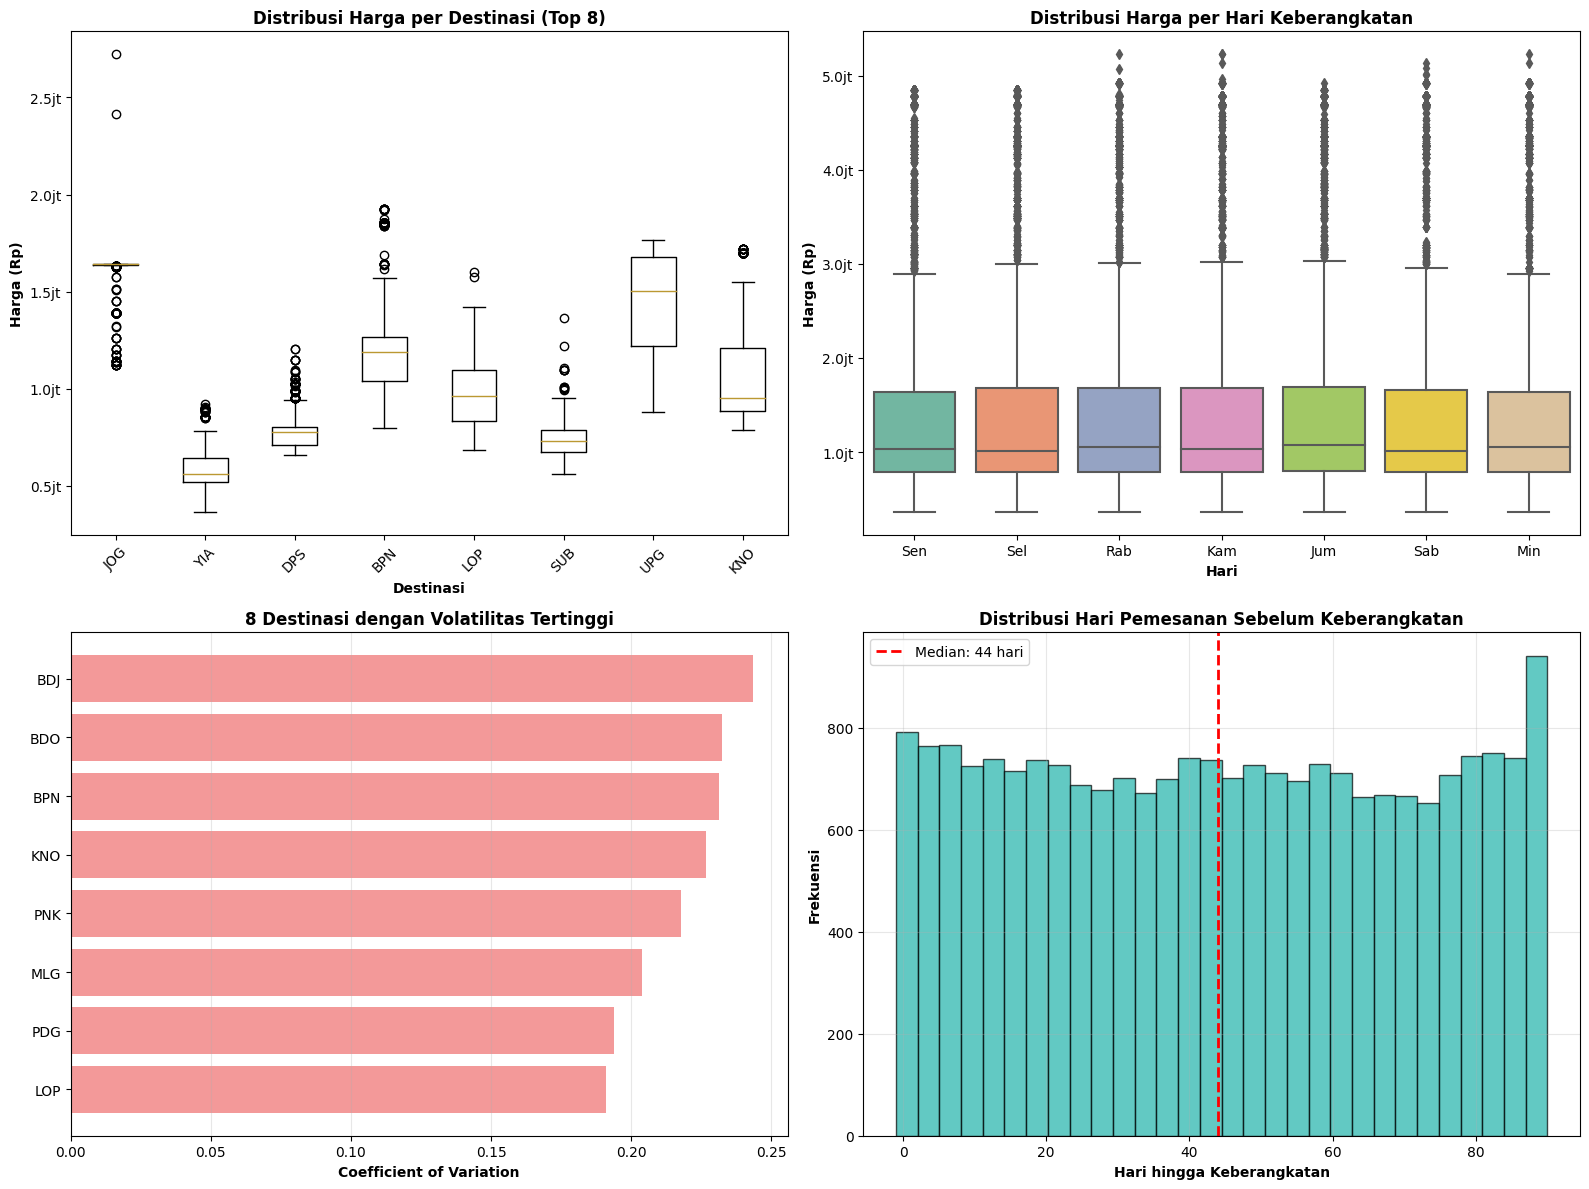


=== INSIGHT DAN REKOMENDASI BISNIS ===

📊 KEY INSIGHTS:
1. TOP 3 DESTINASI: JOG, YIA, DPS
2. WEEKEND PREMIUM: Harga weekend -0.8% dari weekday
3. VOLATILITAS TERTINGGI: BDJ, BDO, BPN
4. RENTANG HARGA: Rp 367,200 - Rp 5,226,620
   IQR (25%-75%): Rp 789,400 - Rp 1,677,930
5. POLA PEMESANAN: Rata-rata 89 hari, Median 95 hari
